<h1> TENSORFLOW MACHINE LEARNING </h1>

In [10]:
# CORE ALGORITHMS

# importing modules
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [11]:
# showing the first 5 rows
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [12]:
# training the feature columns

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # associate every feature name with a list of unique vocabulary

for feature_name in NUMERIC_COLUMNS: 
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) # for the ones with numerical features


# print it
print(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', 

In [13]:
# The training process - Input Function
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
    def input_function(): # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates dataset object with data and its features
        if shuffle:
            ds = ds.shuffle(1000) # randomize the data
        ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into baches of 32 and repeat the process of num of epochs
        return ds # return the batch dataset
    return input_function # return a function to use

train_input_fn = make_input_fn(dftrain, y_train) # get a dataset to train
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs = 1, shuffle = False) # for testing

In [14]:
# Creating the model
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

# Training the model
linear_est.train(train_input_fn) # train the model
result = linear_est.evaluate(eval_input_fn) # testing the model
clear_output() # clear the console for useless training outputs
print(result['accuracy']) # see the accuracy

0.75


In [15]:
# dictionary of one prediction
print(dfeval.loc[0]) # print the person
# print(result[0]['probabilities'][1]) # change of survival: index 1

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object


In [16]:
# print(result[0]['probabilities'][0]) # change of not survival: index 0

In [17]:
print(y_eval.loc[0]) # if they survive or not

0


In [18]:
# Classification

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [19]:
# see the data
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [20]:
# remove the species column and use that as our label
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [21]:
train_y.head() # species stored in train_y 

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [22]:
# shape of our train model
train.shape

(120, 4)

In [23]:
# Input Function
def input_fn(features, labels, training = True, batch_size = 256):
    # converts the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # shuffle (random) and repeat 
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [24]:
# Feature Columns
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key = key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [25]:
# Building the Model

# build a DNN with 2 hidden layers (30 and 10 hidden nodes each)
classifier = tf.estimator.DNNClassifier(feature_columns = my_feature_columns, hidden_units = [30, 10], n_classes = 3)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu69ai6da', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_work

In [26]:
# Training the Model
classifier.train(
    input_fn = lambda: input_fn(train, train_y, training = True), steps = 5000
)

Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpu69ai6da/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2023-12-30 21:53:17.956715: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT64
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'dnn/zero_fraction/cond/output/_18'


INFO:tensorflow:loss = 1.099901, step = 0
INFO:tensorflow:global_step/sec: 348.492
INFO:tensorflow:loss = 0.8974092, step = 100 (0.288 sec)
INFO:tensorflow:global_step/sec: 423.724
INFO:tensorflow:loss = 0.81934476, step = 200 (0.236 sec)
INFO:tensorflow:global_step/sec: 426.223
INFO:tensorflow:loss = 0.7713202, step = 300 (0.235 sec)
INFO:tensorflow:global_step/sec: 429.724
INFO:tensorflow:loss = 0.73479337, step = 400 (0.233 sec)
INFO:tensorflow:global_step/sec: 420.646
INFO:tensorflow:loss = 0.70349723, step = 500 (0.239 sec)
INFO:tensorflow:global_step/sec: 411.197
INFO:tensorflow:loss = 0.6814299, step = 600 (0.242 sec)
INFO:tensorflow:global_step/sec: 434.351
INFO:tensorflow:loss = 0.66264814, step = 700 (0.230 sec)
INFO:tensorflow:global_step/sec: 408.028
INFO:tensorflow:loss = 0.64075315, step = 800 (0.245 sec)
INFO:tensorflow:global_step/sec: 435.265
INFO:tensorflow:loss = 0.620116, step = 900 (0.230 sec)
INFO:tensorflow:global_step/sec: 432.581
INFO:tensorflow:loss = 0.607729

In [27]:
# Testing the Model

eval_result = classifier.evaluate(input_fn = lambda: input_fn(test, test_y, training = False))
print('\nTest set accuracy: {accuracy: 0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-12-30T21:53:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpu69ai6da/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.12541s
INFO:tensorflow:Finished evaluation at 2023-12-30-21:53:30
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.93333334, average_loss = 0.42947653, global_step = 5000, loss = 0.42947653
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpu69ai6da/model.ckpt-5000

Test set accuracy:  0.933



In [28]:
# Predictions

def input_fn(features, batch_size=256):
    # convert the inputs to a Dataset without labels
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpu69ai6da/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Setosa" (100.0%)


In [29]:
# Clustering & K-Means

# probability hot and cold day / weather model 
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions # shortcut
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) #  first day has 80% of being cold and 20% of being hot
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3], [0.2, 0.8]]) # a cold day has 30% change of being followed by a hot day (70% change of being cold)
                                                                         # a hot day has a 20% chance of being followed by a cold day (80% change of being hot)
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.]) # loc = mean and standard deviation (average temperature is 15 and ranges from 5 to 25)

In [30]:
# create the hidden markov model
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution = observation_distribution,
    num_steps = 7 # how many days we want to predict for
)

In [31]:
# to get the expected temperatures on each day
mean = model.mean() # calculate the probabilities

with tf.compat.v1.Session() as sess:
    print(mean.numpy())

[3.        5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]


In [32]:
# Neural Networks
from tensorflow import keras

# dataset includes 60.000 images for training and 10.000 images for testing
fashion_mnist = keras.datasets.fashion_mnist # load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # split into testing and training

In [33]:
# shape of dataset
train_images.shape # 60.000 images and images of 28x28 pixels (784 in total) 28 rows and 28 columns

(60000, 28, 28)

In [34]:
type(train_images) # type of data

numpy.ndarray

In [35]:
train_images[0, 23, 23] # show one pixel (image zero, row 23, columns 23)
# 0 for black and 255 for white

194

In [36]:
print(train_images) # multiple pixels

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [37]:
train_labels[:10] # 10 different classes for dataset / each integer represents a speicific article of clothing

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [38]:
# create an array of label names to indicate which is which
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

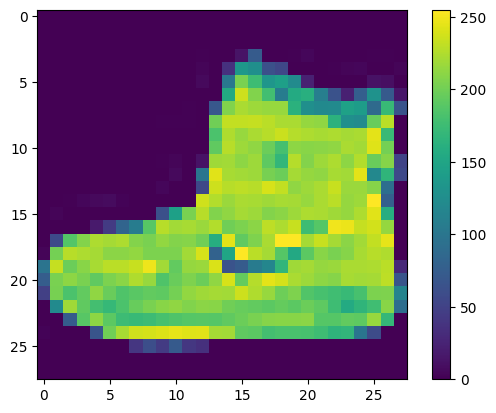

In [46]:
# what the images look like (10 examples)
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

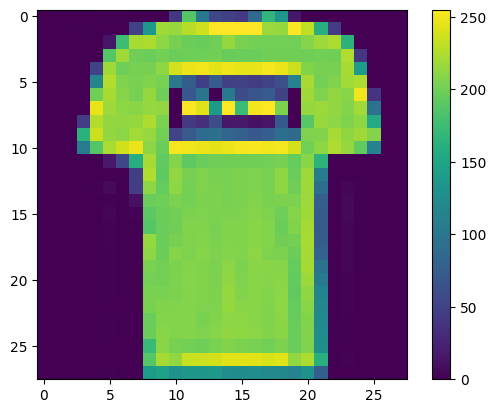

In [47]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

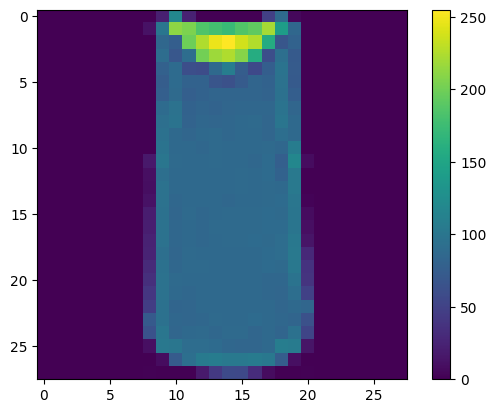

In [48]:
plt.figure()
plt.imshow(train_images[2])
plt.colorbar()
plt.grid(False)
plt.show()

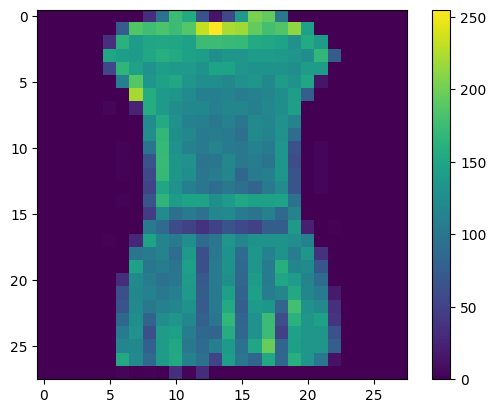

In [49]:
plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)
plt.show()

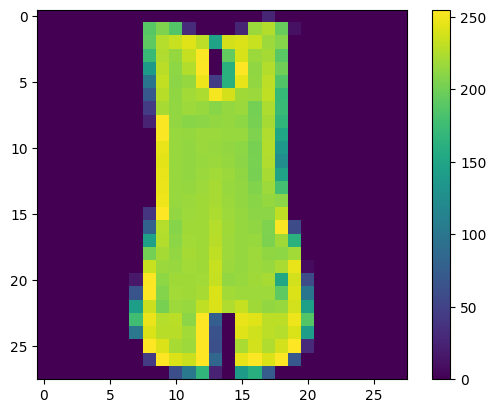

In [50]:
plt.figure()
plt.imshow(train_images[4])
plt.colorbar()
plt.grid(False)
plt.show()

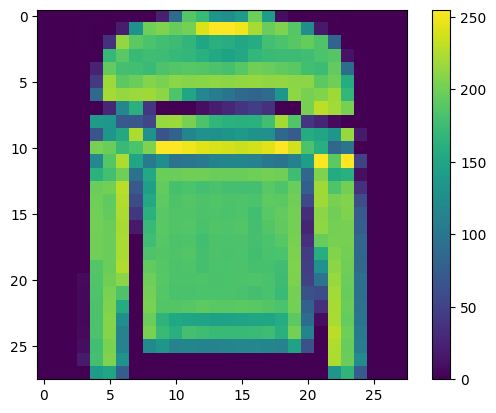

In [51]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

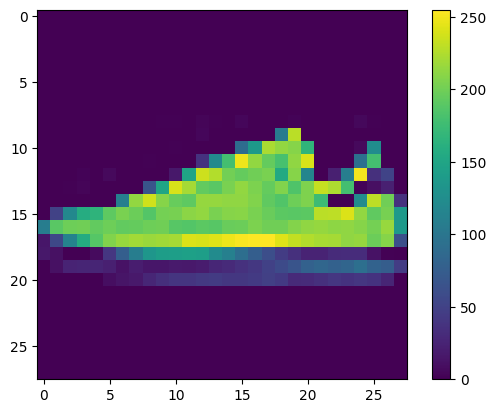

In [52]:
plt.figure()
plt.imshow(train_images[6])
plt.colorbar()
plt.grid(False)
plt.show()

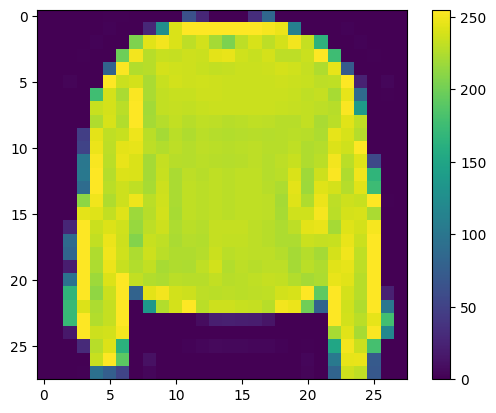

In [53]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

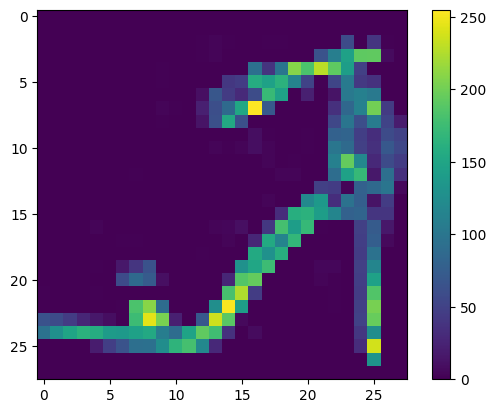

In [54]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.grid(False)
plt.show()

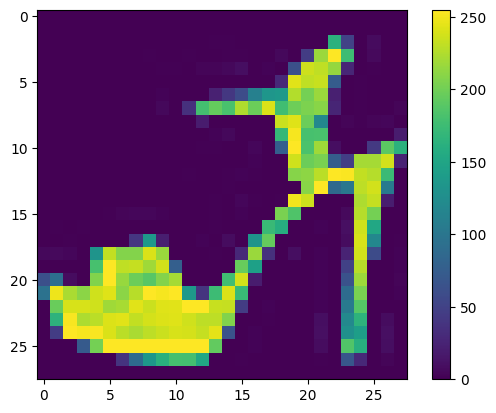

In [55]:
plt.figure()
plt.imshow(train_images[9])
plt.colorbar()
plt.grid(False)
plt.show()

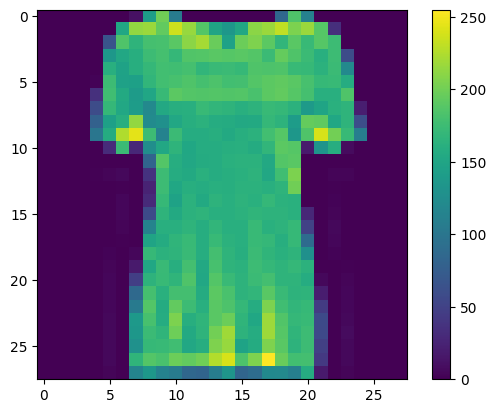

In [56]:
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.grid(False)
plt.show()

In [57]:
# Data Preprocessing

# squish all the values from 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0